# Perspective transformtaion for robot picking
Sometimes, the detection of an object can be facilitated by seeing it from another viewpoint. But it is not always possible to place the camera at this viewpoint due to possible mounting constraints. In this application, a robot needs to pick up a ball. To be convenient, the camera should be placed in such a way that we obtain a top view of the ball. But as this would be in the robot moving area, this is not possible. Therefore, we need to place the camera at an angle, pointing towards the robot moving area. Imaging an object from this viewpoint results in a deformed image due to perspective projection in the camera. For a ball, this is not really a problem, but for any other object it can be. For this application, we use a ball for convenience. We have three images, a first image of a chessboard pattern in the required camera view, a second image of a chesboard pattern in a topview, and a third image of a ball from the required view. The goal is to warp the third image af is it was shot from the top view so that detection could be made easier.

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

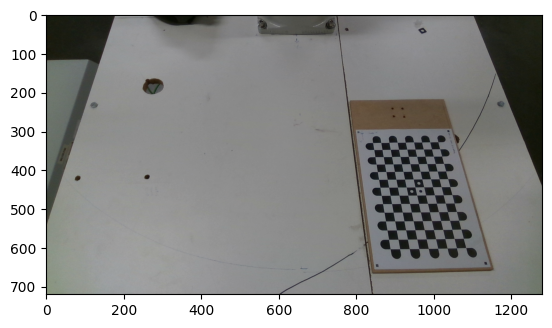

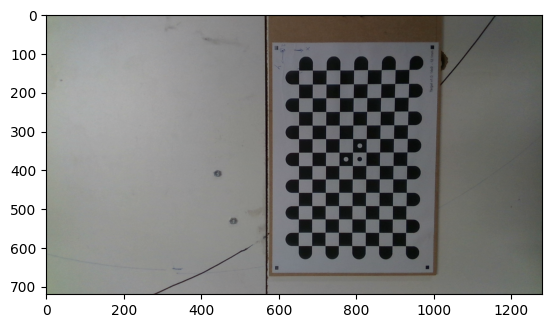

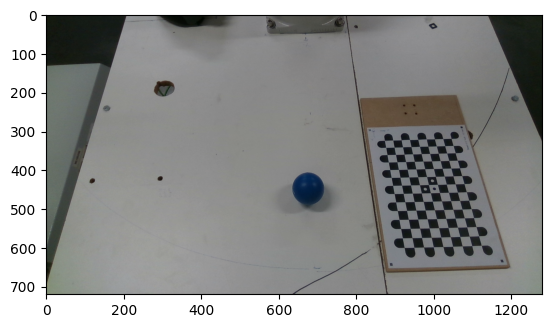

In [2]:
# Read images
image1 =  cv2.cvtColor(cv2.imread('../../data/perspective_1_Color.png'), cv2.COLOR_BGR2RGB)
image2 =  cv2.cvtColor(cv2.imread('../../data/perspective_2_Color.png'), cv2.COLOR_BGR2RGB)
image3 =  cv2.cvtColor(cv2.imread('../../data/perspective_1_ball_Color.png'), cv2.COLOR_BGR2RGB)

# Show images
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()

We are looking for the perspective transformation between the two views. Therefore, we use the chessboard pattern in both views where we detect the chessboard corners, and use the corner points of both images to calculate the perspective transformation. Lastly, the image with the ball is warped using this perspective transformation. 

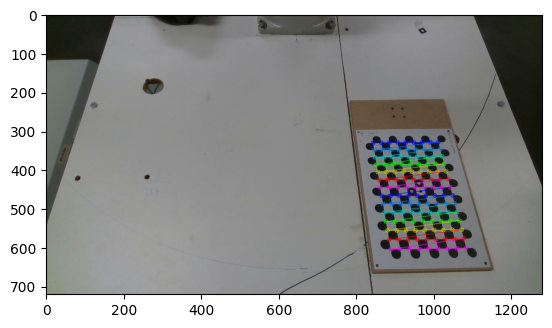

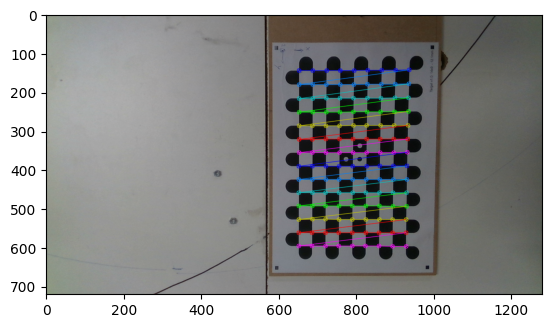

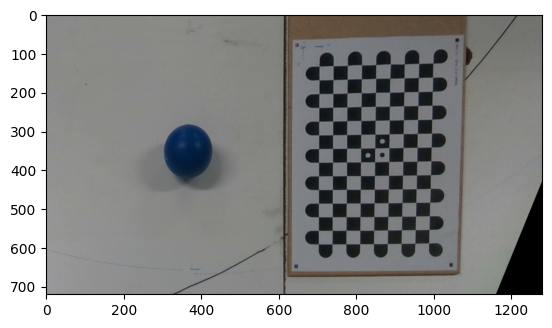

In [3]:
# Convert to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Get chessboard corners
ret, corners1 = cv2.findChessboardCornersSB(gray1, (9, 14), cv2.CALIB_CB_MARKER)
ret, corners2 = cv2.findChessboardCornersSB(gray2, (9, 14), cv2.CALIB_CB_MARKER)

# Show chessboard corners on application view
cv2.drawChessboardCorners(image1, (9,14), corners1,ret)
plt.imshow(image1)
plt.show()

# Show chessboard corners on top view
cv2.drawChessboardCorners(image2, (9,14), corners2,ret)
plt.imshow(image2)
plt.show()

# Retrieve the four corners on the outer corners of the chessboard
corners1 = np.array([corners1[0], corners1[8], corners1[-1], corners1[-9]])
corners2 = np.array([corners2[0], corners2[8], corners2[-1], corners2[-9]])

# Get perspective transformation between the two viewpoints
M = cv2.getPerspectiveTransform(np.float32(np.resize(corners1, (4, 2))), np.float32(np.resize(corners2, (4, 2))))

# Warp the image with the ball to the top view
dst = cv2.warpPerspective(image3, M, (np.shape(image1)[1], np.shape(image1)[0]))

# Show warped image
plt.imshow(dst)
plt.show()

Next, we use the transfromed image to obtain a mask of the ball using image processing, and detect the ball center in pixel coordinates. The HSV threshold values were calibrated earlier.

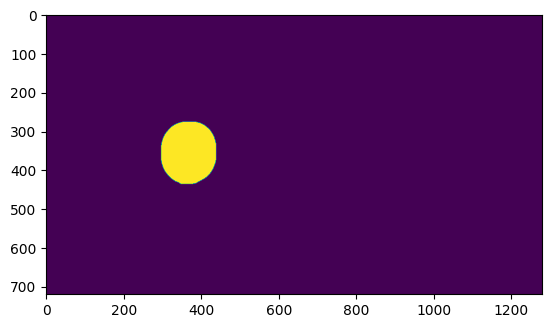

In [4]:
# Get HSV calibration params 
hsvfile = np.load('../../data/demo1_hsv.npy')

# Gaussian blur
blurred_image = cv2.GaussianBlur(dst, (7, 7), 0)

# Convert to hsv color space
hsv = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)

# Get mask
mask = cv2.inRange(hsv, np.array([hsvfile[0], hsvfile[2], hsvfile[4]]), np.array([hsvfile[1], hsvfile[3], hsvfile[5]]))

# Erode to close gaps
mask = cv2.erode(mask, np.ones((6, 6), np.uint8) , iterations=2)

# Dilate to get original size
mask = cv2.dilate(mask, np.ones((15, 15), np.uint8) , iterations=2)

# Show mask
plt.imshow(mask)
plt.show()

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find contour with largest area
maxcontour = max(contours, key=cv2.contourArea)

# Find radius of circle
((x, y), radius) = cv2.minEnclosingCircle(maxcontour)

# Get center pixel
center = (int(x), int(y))


Once we obtained the center of the ball in the warped image, we can trasform this coordinate back to the original viewpoint so that we can have the ball detected in this viewpoint. 

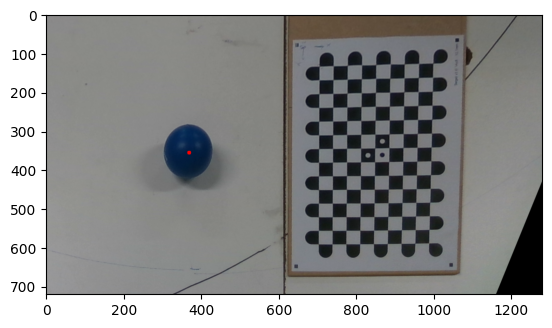

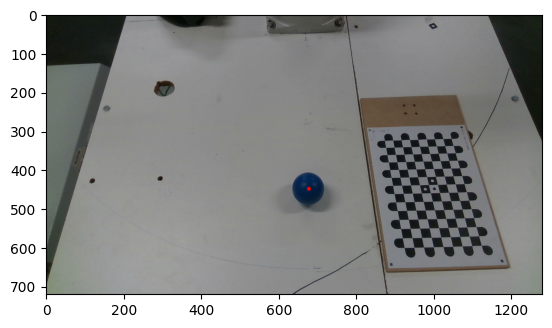

In [5]:
# Plot ball pixel
tmp = cv2.circle(dst.copy(), center, 5, (255, 0, 0), -1)

# Show
plt.imshow(tmp)
plt.show()

# Transform pixel back to original image plane
new_pixel = np.dot(np.linalg.inv(M), np.array([[center[0]], [center[1]], [1]]))
center = [int(new_pixel[0][0]/new_pixel[2][0]), int(new_pixel[1][0]/new_pixel[2][0])]

# Plot ball pixel on original ball image
cv2.circle(image3, center, 5, (255, 0, 0), -1)

# Show
plt.imshow(image3)
plt.show()

